# Chargement des données

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
from torchvision import datasets, transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.utils import compute_class_weight

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
# définition des transformations
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(), #augmentation
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #d'après une discution avec le coach
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [33]:
#Chargement des images dans des datasets
path_test = '../dataset/car_data/car_data/test'
path_train = '../dataset/car_data/car_data/train'

train_dataset = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset)}')
print(f'Test dataset size is {len(test_dataset)}')

Train dataset size is 8144
Test dataset size is 8041


In [34]:
df_names = pd.read_csv('../dataset/names.csv', names=['name'])

In [35]:
#Convertion des datasets en dataLoader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

# Chargement du modèle

In [36]:
#nombre de classes présentes dans les données
no_classes = len(train_dataset.classes)

In [37]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.parameters

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [38]:
# On constate que le dernier layer contient trop de sorties.
# On le remplace donc par un nouveau layer avec le nombre de classes que nous avons dans nos données
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# Evaluation Step

In [39]:
import torch
from tqdm import tqdm

def eval_model(model, test_loader, device, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader), 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    test_acc = 100.0 * correct / total
    print('Accuracy sur le dataset de test: %d %%' % (
        test_acc))
    return test_acc

# Training Step

In [40]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        
        for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==preds).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Fin entraînement')
    return model, losses, accuracies, test_accuracies

This is where we call the function to start training the model

In [42]:
n_epochs = 10
# Entrainement du modèle
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Sauvegarde du modèle
torch.save(model.state_dict(), 'model.pth')

100%|██████████| 255/255 [06:12<00:00,  1.46s/it]


Epoch 1, duration: 372 s, loss: 3.7603, acc: 19.1422


100%|██████████| 252/252 [00:46<00:00,  5.46it/s]


Accuracy sur le dataset de test: 37 %


100%|██████████| 255/255 [06:15<00:00,  1.47s/it]


Epoch 2, duration: 375 s, loss: 1.8760, acc: 56.3725


100%|██████████| 252/252 [00:45<00:00,  5.58it/s]


Accuracy sur le dataset de test: 59 %


100%|██████████| 255/255 [06:18<00:00,  1.48s/it]


Epoch 3, duration: 378 s, loss: 1.0043, acc: 77.3284


100%|██████████| 252/252 [00:46<00:00,  5.43it/s]


Accuracy sur le dataset de test: 72 %


100%|██████████| 255/255 [06:18<00:00,  1.48s/it]


Epoch 4, duration: 378 s, loss: 0.6324, acc: 85.5637


100%|██████████| 252/252 [00:44<00:00,  5.64it/s]


Accuracy sur le dataset de test: 75 %


100%|██████████| 255/255 [06:21<00:00,  1.50s/it]


Epoch 5, duration: 381 s, loss: 0.4130, acc: 90.8701


100%|██████████| 252/252 [00:45<00:00,  5.49it/s]


Accuracy sur le dataset de test: 81 %


 57%|█████▋    | 146/255 [03:39<02:43,  1.50s/it]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(path_train)

In [ ]:
# model = models.resnet18(pretrained=True)
# model.load_state_dict(torch.load('model.pth'))
# model.eval()

model.eval()

loader = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin V8 Vantage Convertible 2012/00239.jpg' #mettre une vraie image random et intégrer l'explicabilité ici
image = Image.open(os.path.join(path_test, random_image_name))

image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)

image = image.unsqueeze(0)
image = image.cuda()
output = model(image)

conf, predicted = torch.max(output.data, 1)

In [ ]:
display(Image.open(os.path.join(path_test, random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())

# Evaluation Metrics calculation
Precision, Recall, and F1-Measure are calculated here.

In [ ]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

cr = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(cr)

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,10))

class_names = list(df_names['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better
for i in range(len(df_cm)):
    df_cm.iat[i, i] = 0
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
figure = heatmap.get_figure()    
figure.savefig('matrice_confusion.png', dpi=400)

In [ ]:
np.savetxt('cm.csv', cm, delimiter=',', fmt='%d')

In [ ]:
# Load the model and train it
model = torch.load('model.pth')
#T

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# définition des transformations
train_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.RandomHorizontalFlip(), #augmentation
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #d'après une discution avec le coach
test_tfms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
#Chargement des images dans des datasets
path_test = '../dataset/car_data/car_data/test'
path_train = '../dataset/car_data/car_data/train'

train_dataset = datasets.ImageFolder(root=path_train, transform = train_tfms)

test_dataset = datasets.ImageFolder(root=path_test, transform = test_tfms)

print(f'Train dataset size is {len(train_dataset)}')
print(f'Test dataset size is {len(test_dataset)}')

Train dataset size is 8144
Test dataset size is 8041


In [9]:
df_names = pd.read_csv('../dataset/names.csv', names=['name'])

In [10]:
#Convertion des datasets en dataLoader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

# Chargement du modèle

In [11]:
#nombre de classes présentes dans les données
no_classes = len(train_dataset.classes)

In [12]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.parameters

C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [13]:
# On constate que le dernier layer contient trop de sorties.
# On le remplace donc par un nouveau layer avec le nombre de classes que nous avons dans nos données
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# Définition de la fonction de Loss et de l'optimisation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

# Evaluation Step

In [14]:
import torch
from tqdm import tqdm

def eval_model(model, test_loader, device, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader), 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    test_acc = 100.0 * correct / total
    print('Accuracy sur le dataset de test: %d %%' % (
        test_acc))
    return test_acc

# Training Step

In [15]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []

    model.train()
    
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        
        for i, data in enumerate(tqdm(train_loader), 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==preds).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Fin entraînement')
    return model, losses, accuracies, test_accuracies

This is where we call the function to start training the model

In [29]:
n_epochs = 20
# Entrainement du modèle
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Sauvegarde du modèle
torch.save(model.state_dict(), 'model.pth')

AttributeError: 'collections.OrderedDict' object has no attribute 'train'

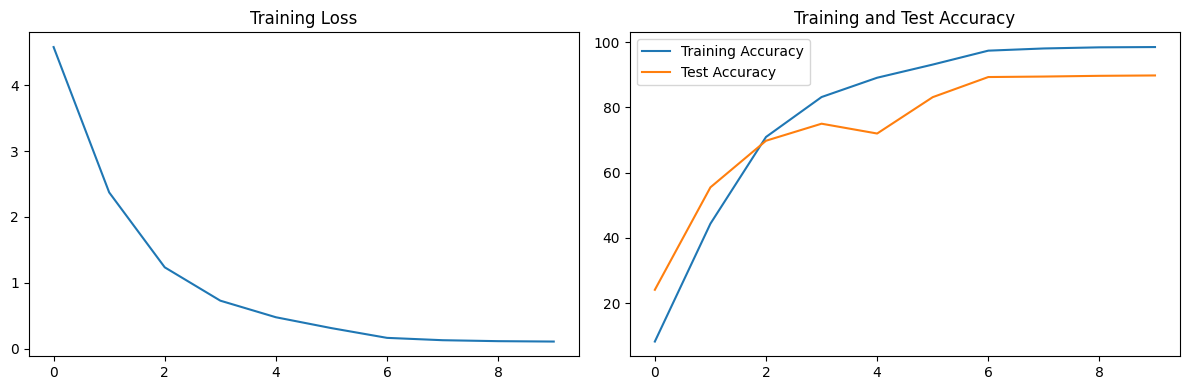

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


In [18]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(path_train)

In [19]:
# model = models.resnet18(pretrained=True)
# model.load_state_dict(torch.load('model.pth'))
# model.eval()

model.eval()

loader = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin V8 Vantage Convertible 2012/00239.jpg' #mettre une vraie image random et intégrer l'explicabilité ici
image = Image.open(os.path.join(path_test, random_image_name))

image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)

image = image.unsqueeze(0)
image = image.cuda()
output = model(image)

conf, predicted = torch.max(output.data, 1)

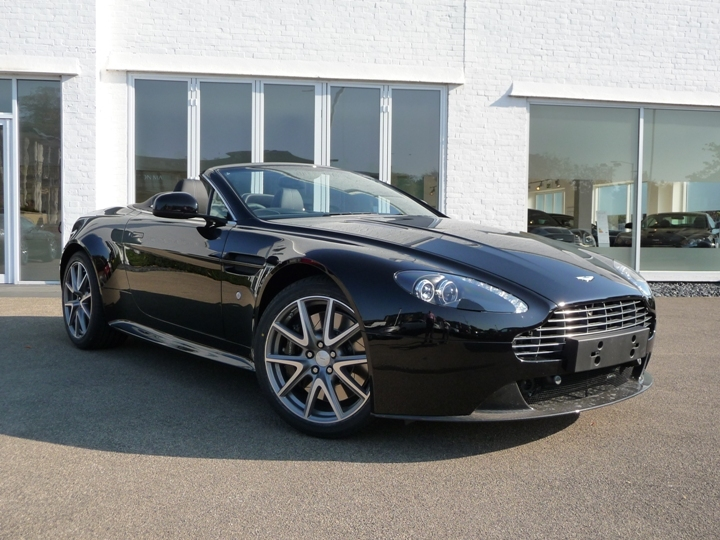

Infiniti G Coupe IPL 2012 confidence:  17.95096778869629


In [20]:
display(Image.open(os.path.join(path_test, random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())

# Evaluation Metrics calculation
Precision, Recall, and F1-Measure are calculated here.

In [21]:
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)

cr = classification_report(true_labels, predicted_labels)

print("\nClassification Report:")
print(cr)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.91      0.95      0.93        44
           2       0.90      0.81      0.85        32
           3       0.81      1.00      0.90        43
           4       1.00      0.95      0.98        42
           5       0.95      0.93      0.94        40
           6       0.88      0.90      0.89        39
           7       0.70      0.78      0.74        45
           8       0.82      0.80      0.81        41
           9       0.96      0.70      0.81        33
          10       0.89      0.84      0.86        38
          11       0.70      0.75      0.72        40
          12       0.70      0.76      0.73        42
          13       0.71      0.88      0.78        41
          14       0.95      0.95      0.95        43
          15       0.92      0.92      0.92        36
          16       0.89      0.91      0.90        45
   

Text(0.5, 80.7222222222222, 'Predicted label')

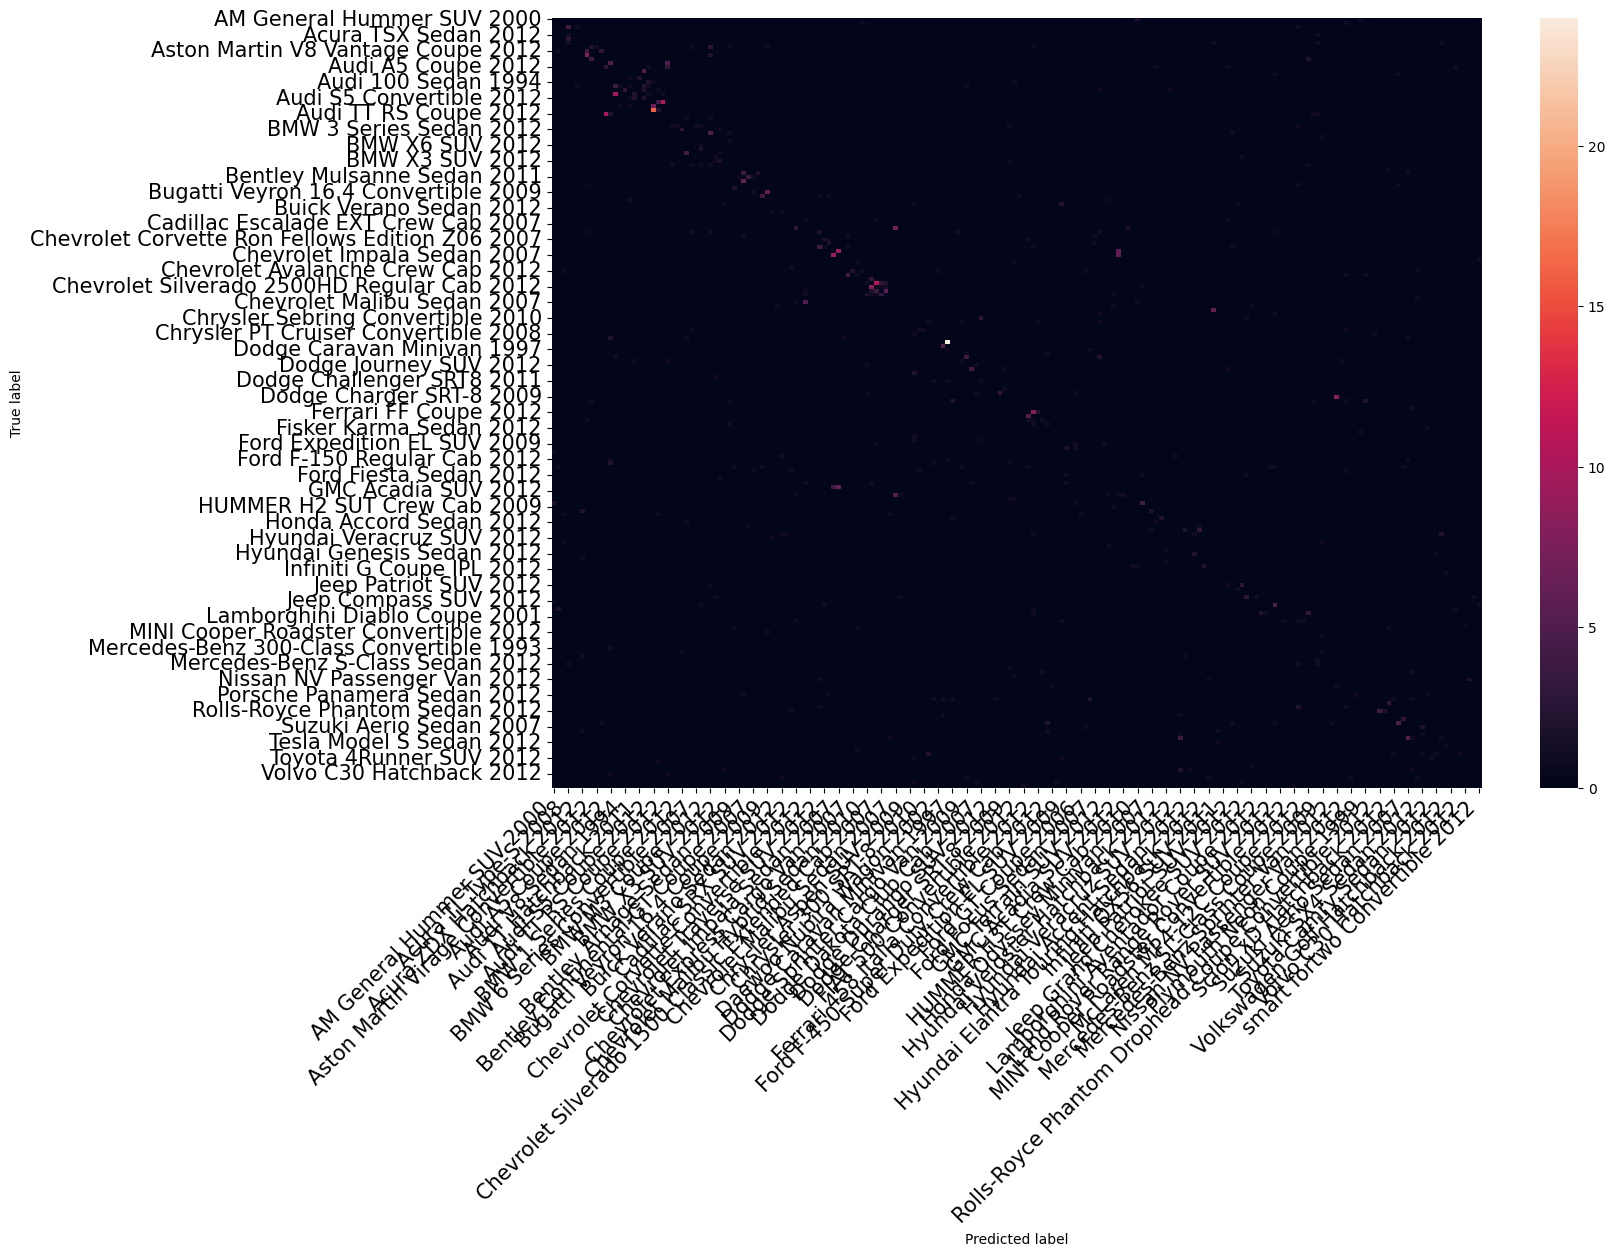

In [26]:
import seaborn as sns

plt.figure(figsize=(15,10))

class_names = list(df_names['name'])

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names).astype(int)
#Set the diagonal to zero, so we can see the other values better
for i in range(len(df_cm)):
    df_cm.iat[i, i] = 0
heatmap = sns.heatmap(df_cm)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [23]:
figure = heatmap.get_figure()    
figure.savefig('matrice_confusion.png', dpi=400)

In [24]:
np.savetxt('cm.csv', cm, delimiter=',', fmt='%d')